##**Imports**

In [1]:
# !pip install mlflow --quiet

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

In [3]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Utility Functions**

In [4]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    MAX_FILE_COUNT = 250
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    # file_list.count
    cnt = 0
    for file in file_list:
        cnt += 1
        if cnt > MAX_FILE_COUNT: #Stop creating files in the local directory if the number of files > MAX_FILE_COUNT
          break
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass

##**Step 0: If you have already created the Train, Validation and Test datasets and stored it in GDrive then you can skip Steps 1 and 2 (otherwise skip Step 0 and go to Step 1)**

In [5]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1_difVXO-_N1iMFzxMP2IFeD7e8tUhRBV' #F
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = '' # '1wh7Efgtn3Jeu5Ox6Xw-fNfHAmDYRTyTC'

root = './data/processed'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

search_processed_datasets_folder(processed_datasets_folder_id, root) # search_processed_datasets_folder(waesche_folder_id, root) X
f.close()

Creating folder: ./data/processed/bag
Creating folder: ./data/processed/bag/test_dataset
Creating folder: ./data/processed/bag/test_dataset/7675821213704089024
Creating folder: ./data/processed/bag/test_dataset/7675821213704089024/00000000.shard
Creating folder: ./data/processed/bag/test_dataset/1066113611490136018
Creating folder: ./data/processed/bag/test_dataset/1066113611490136018/00000000.shard
Creating folder: ./data/processed/bag/train_dataset
Creating folder: ./data/processed/bag/train_dataset/13566746268163081920
Creating folder: ./data/processed/bag/train_dataset/13566746268163081920/00000000.shard
Creating folder: ./data/processed/bag/train_dataset/6007611454123508922
Creating folder: ./data/processed/bag/train_dataset/6007611454123508922/00000000.shard
Creating folder: ./data/processed/bag/val_dataset
Creating folder: ./data/processed/bag/val_dataset/8589842609783317368
Creating folder: ./data/processed/bag/val_dataset/8589842609783317368/00000000.shard
Creating folder: ./d

In [6]:
PRODUCT_CATEGORY = 'waesche' # 'clothes'
# GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_SHAPE = (427, 350, 3)

# CLASSES = ['clothes_0_model_front'
#            , 'clothes_1_zoomed'
#            , 'clothes_2_model_back'
#            , 'clothes_3_ghost'
#            , 'clothes_4_look'
#            ]

CLASSES = ['waesche_0_model_front'
           , 'waesche_1_zoomed'
           , 'waesche_2_model_back'
           , 'waesche_3_ghost'
           , 'waesche_4_look'
           ]

train_ds = tf.data.experimental.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset') # FIXME: WARNING:tensorflow:From <ipython-input-5-fb5572270b8c>:21: load (from tensorflow.python.data.experimental.ops.io) is deprecated and will be removed in a future version.
                                                                                           # Instructions for updating: Use `tf.data.Dataset.load(...)` instead.
val_ds = tf.data.experimental.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.experimental.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [7]:
# classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
# print("Class distribution in Train:")
# for value, count in zip(classes, class_count):
#     print(f"{CLASSES[value]} occurs {count} times")

In [8]:
# classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
# print("Class distribution in Validation:")
# for value, count in zip(classes, class_count):
#     print(f"{CLASSES[value]} occurs {count} times")

In [9]:
# classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
# print("Class distribution in Test:")
# for value, count in zip(classes, class_count):
#     print(f"{CLASSES[value]} occurs {count} times")

In [10]:
# for images, labels in test_ds.take(2):
#   for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(CLASSES[labels[i]])
#     plt.axis("off")


In [11]:
# for images, labels in test_ds.take(4):
#   print("First mismatch index 156 (i.e. 28 in the 5th batch of 32 images):")
#   plt.imshow(images[27].numpy().astype("uint8"))
#   plt.title(CLASSES[labels[27]])
#   # print(f"Predicted Class = {y_pred[156]}")
#   plt.axis("off")

#   print("Second mismatch index 160 (i.e. 32 in the 5th batch of 32 images):")
#   plt.imshow(images[31].numpy().astype("uint8"))
#   plt.title(CLASSES[labels[31]])
#   # print(f"Predicted Class = {y_pred[160]}")
#   plt.axis("off")

# for images, labels in test_ds.take(7):
#   print("Third mismatch index 241 (i.e. 17 in the 8th batch of 32 images):")
#   plt.imshow(images[16].numpy().astype("uint8"))
#   plt.title(CLASSES[labels[16]])
#   # print(f"Predicted Class = {y_pred[241]}")
#   plt.axis("off")

## **Step 1: Importing the Image data from Google drive**

**Note:** we figured out how to download a nested folder structure allong with the files from Google Drive (instead of just one file) from the following StackOverflow discussion - https://stackoverflow.com/questions/46155300/pydrive-error-no-downloadlink-exportlinks-for-mimetype-found-in-metadata

In [12]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# f = open("failed.txt","w+")
# # folder_id = '17NfTjPmDwCB5WO3FgM83Bmgdc631e8Ac' # Folder ID for image_data folder in Best Secrets GDrive (/Best Secret/Data/image_data)
# folder_id = '1Dw7Ae8--BC0I5ROvg36sZB9nZSsGQnyv' # Folder ID for data_not_cleaned folder in Best Secrets GDrive (/Best Secret/Data/data_not_cleaned)

# # Note: these folders should match the final project folder structure we create and may need to be updated
# root = './data/raw'
# # If the folders that we want to download the images to do not exit then create them as shown below:
# if not os.path.isdir("./data"):
#   os.mkdir('./data')

# if not os.path.isdir("./data/raw"):
#   os.mkdir('./data/raw')

# search_folder(folder_id,root+'/')
# f.close()

In [13]:
# get_folder_info(folder_id)

##**Step 2: Load image data and split them into Train, Validation and Test**

### **Step 2.1: Process the data from Step 1:**

**Note:** there is a script we can run to find corrupted images. We ran this script and found an image (./image_data/raw/clothes/clothes_1_zoomed/32760559-001.jpg') that was corrupted and deleted it from the directory so it does not cause issues down stream when we train our models

In [14]:
# import pathlib
# root = './data/raw'
# data_dir = pathlib.Path(root)
# data_dir

In [15]:
# !sudo apt-get install tree

In [16]:
# !tree --dirsfirst --filelimit 6 './data/raw'

In [17]:
# image_count = len(list(data_dir.glob('*/*/*.jpg')))
# print(f"Total number of images across all categories and classes = {image_count}")

In [18]:
# clothes_0_model_front = list(data_dir.glob('bag/bag_0/*.jpg'))

In [19]:
# PIL.Image.open(str(clothes_0_model_front[4]))

In [20]:
# from struct import unpack
# from tqdm import tqdm
# import os

# marker_mapping = {
#     0xffd8: "Start of Image",
#     0xffe0: "Application Default Header",
#     0xffdb: "Quantization Table",
#     0xffc0: "Start of Frame",
#     0xffc4: "Define Huffman Table",
#     0xffda: "Start of Scan",
#     0xffd9: "End of Image"
# }

# class JPEG:
#     def __init__(self, image_file):
#         with open(image_file, 'rb') as f:
#             self.img_data = f.read()

#     def decode(self):
#         data = self.img_data
#         while(True):
#             marker, = unpack(">H", data[0:2])
#             # print(marker_mapping.get(marker))
#             if marker == 0xffd8:
#                 data = data[2:]
#             elif marker == 0xffd9:
#                 return
#             elif marker == 0xffda:
#                 data = data[-2:]
#             else:
#                 lenchunk, = unpack(">H", data[2:4])
#                 data = data[2+lenchunk:]
#             if len(data)==0:
#                 raise TypeError("issue reading jpeg file")

# bads = []

# img_dir = root

# for dirName, subdirList, fileList in os.walk(img_dir):
#     imagesList = fileList
#     for img in tqdm(imagesList):
#         image = os.path.join(dirName,img)
#         image = JPEG(image)
#         try:
#             image.decode()
#         except:
#             bads.append(dirName+'/'+img)

# #Show the bad images
# bads

# #remove the bad images
# # note: we found the following image that was corrupted that we removed - ./raw/clothes/clothes_1_zoomed/32760559-001.jpg'
# # for name in bads:
# #   os.remove(name)

**The script above found one corrupted image in the clothes_1_zoomed folder - './data/raw/clothes/clothes_1_zoomed/32760559-001.jpg'**

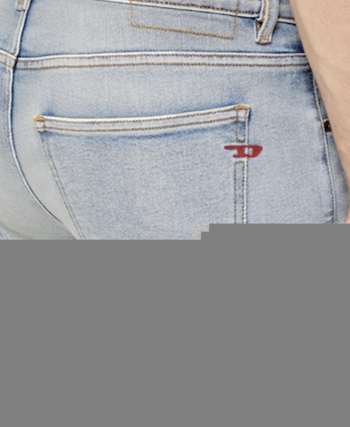

In [21]:
# bads

In [22]:
# # Delete the corrupted image from the folder
# for name in bads:
#   os.remove(name)

In [23]:
# # Image count after deleting the corrupted image
# image_count = len(list(data_dir.glob('*/*/*.jpg')))
# print(f"Total number of images across all categories and classes = {image_count}")

###**Step 2.1: Split data into Train, Validatin and Test**

In [24]:
# RANDOM_SEED = 42
# #VAL_SPLIT = 0.4
# PRODUCT_CATEGORY = 'clothes' # 'waesche' 'schuhe' 'bag'
# BATCH_SIZE = 32
# IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
# IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
# SHUFFLE = True

# PROD_DATA_DIR = pathlib.Path(root+'/'+PRODUCT_CATEGORY)
# CLASSES = [PRODUCT_CATEGORY+'_0'
#            , PRODUCT_CATEGORY+'_1'
#            , PRODUCT_CATEGORY+'_2'
#            , PRODUCT_CATEGORY+'_3'
#            , PRODUCT_CATEGORY+'_4'
#            ]

# # This code gives the classes
# # for item in os.scandir(PROD_DATA_DIR):
# #     if not item.name.startswith('.'): #dont include any hidden files or dirs that may be in the folder (more applicable when running on local machine)
# #         CLASSES.append(item.name)

In [25]:
CLASSES

['waesche_0_model_front',
 'waesche_1_zoomed',
 'waesche_2_model_back',
 'waesche_3_ghost',
 'waesche_4_look']

In [26]:
# full_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   directory = PROD_DATA_DIR,
#   seed=RANDOM_SEED,
#   class_names=CLASSES,
#   image_size=(IMG_HEIGHT, IMG_WIDTH),
#   batch_size=BATCH_SIZE,
#   shuffle = SHUFFLE)

# ds_batches = tf.data.experimental.cardinality(full_ds)
# train_ds = full_ds.take(((ds_batches) * 3) // 5) #60% of the data for training
# val_test_ds = full_ds.skip(((ds_batches) * 3) // 5) #40% of the remaining data for validation and test

# val_test_batches = tf.data.experimental.cardinality(val_test_ds)
# val_ds = val_test_ds.take((val_test_batches) // 2) #50% of the val_test_ds for validation (20% of full_ds)
# test_ds = val_test_ds.skip((val_test_batches) // 2) #50% of the val_test_ds for Test (20% of full_ds)

# print(f'Train data size = {len(train_ds)*BATCH_SIZE}')
# print(f'Validation data size = {len(val_ds)*BATCH_SIZE}')
# print(f'Test data size = {len(test_ds)*BATCH_SIZE}')

# # val_ds = tf.keras.preprocessing.image_dataset_from_directory(
# #   directory = PROD_DATA_DIR,
# #   validation_split=VAL_SPLIT,
# #   subset="validation",
# #   seed=RANDOM_SEED,
# #   class_names=CLASSES,
# #   image_size=(IMG_HEIGHT, IMG_WIDTH),
# #   batch_size=BATCH_SIZE,
# #   shuffle = SHUFFLE)

In [27]:
# classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
# print("Class distribution in Train:")
# for value, count in zip(classes, class_count):
#     print(f"{CLASSES[value]} occurs {count} times")

In [28]:
# classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
# print("Class distribution in Validation:")
# for value, count in zip(classes, class_count):
#     print(f"{CLASSES[value]} occurs {count} times")

In [29]:
# classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
# print("Class distribution in Test:")
# for value, count in zip(classes, class_count):
#     print(f"{CLASSES[value]} occurs {count} times")

###**Step 2.3: Save the Train, Val and Test tensor datasets so it can saved in a Google Drive to be used later. That way we dont have to download all images again and it is muh faster to train a new model with the same data (refer to Step 0)**

In [30]:
# if not os.path.isdir("./data/processed"):
#   os.mkdir('./data/processed')

# if not os.path.isdir("./data/processed/"+PRODUCT_CATEGORY):
#   os.mkdir("./data/processed/"+PRODUCT_CATEGORY)

# tf.data.Dataset.save(train_ds, './data/processed/'+PRODUCT_CATEGORY+'/train_dataset')
# tf.data.experimental.save(val_ds, './data/processed/'+PRODUCT_CATEGORY+'/val_dataset')
# tf.data.experimental.save(test_ds, './data/processed/'+PRODUCT_CATEGORY+'/test_dataset')

In [31]:
# # Check that the label and images match
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(CLASSES[labels[i]])
#     plt.axis("off")

## **Step 3: Create and train the base CNN model**

In [32]:
# # The caching helps speed up training after the first batch as the data is pulled from the cache for subsequent batches
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# def create_base_model(activation, initializer, regularizer, dropout_rate, num_start_cnn_neurons=32, num_dense_neurons=256):
#     model = tf.keras.Sequential([

#       tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

#       tf.keras.layers.Conv2D(filters=num_start_cnn_neurons, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
#       tf.keras.layers.MaxPooling2D(),
#       tf.keras.layers.Dropout(rate=dropout_rate),

#       tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*2, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
#       tf.keras.layers.MaxPooling2D(),
#       tf.keras.layers.Dropout(rate=dropout_rate),

#       tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*4, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
#       tf.keras.layers.MaxPooling2D(),
#       tf.keras.layers.Dropout(rate=dropout_rate),

#       tf.keras.layers.Flatten(),

#       tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
#       tf.keras.layers.Dropout(rate=dropout_rate),

#       tf.keras.layers.Dense(len(CLASSES), activation='softmax')

#     ])
#     return model

In [34]:
# ACTIVATIONS = ['relu'
#               #  , 'leaky_relu'
#               #  , 'elu'
#               #  , 'tanh'
#               #  , 'selu'
#               ]
# INITIALIZERS = ['glorot_uniform'
#                 # , 'glorot_normal'
#                 # , 'he_normal'
#                 # , 'lecun_normal'
#                ]


# KERNEL_REGULARIZERS = [ None
#                       #  , 'l1'
#                       #  , 'l2'
#                       #  , 'l1_l2'
#                       ]

# DROPOUT_RATE = [0.0
#                 # , 0.05
#                 # , 0.1
#                 # , 0.2
#                 # , 0.25
#                 ]
# NUM_START_CNN_NEURONS = [32]
# NUM_DENSE_NEURONS = [256]

# EPOCHS = 20
# BATCH_SIZE = 32
# INITIAL_LEARNING_RATE = 0.001
# FINAL_LEARNING_RATE = 0.00001
# LEARNING_RATE_DECAY_FACTOR = (FINAL_LEARNING_RATE / INITIAL_LEARNING_RATE)**(1/EPOCHS)
# STEPS_PER_EPOCH = len(test_ds) # this should actually be set to int(train_size/batch_size), but since the len(test_ds) returns the number of training records divided by the batch size already we just set it to that

# # LR_SCHEDULE = 0.0001

# training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'CNN_Start_Neurons', 'Dense_Neurons', 'Accuracy_Score'])

# i=0
# # with mlflow.start_run():
#     # mlflow.sklearn.autolog()
# for activation in ACTIVATIONS:
#     for initializer in INITIALIZERS:
#         for regularizer in KERNEL_REGULARIZERS:
#             for dropout_rate in DROPOUT_RATE:
#                 for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
#                     for num_dense_neurons in NUM_DENSE_NEURONS:
#                         print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
#                         print("="*80)

#                         model_base = create_base_model(activation, initializer, regularizer, dropout_rate, num_start_cnn_neurons, num_dense_neurons)

#                         LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
#                             initial_learning_rate = INITIAL_LEARNING_RATE,
#                             decay_steps = STEPS_PER_EPOCH,
#                             decay_rate=LEARNING_RATE_DECAY_FACTOR,
#                             staircase=True)

#                         model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
#                                       loss="sparse_categorical_crossentropy",
#                                       metrics=['accuracy'])

#                         early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

#                         history_base = model_base.fit(
#                                         x=train_ds,
#                                         batch_size=BATCH_SIZE,
#                                         epochs=EPOCHS,
#                                         verbose="auto",
#                                         callbacks=[early_stopping_cb],
#                                         validation_data=val_ds
#                                         # class_weight=None,
#                                         # sample_weight=None,
#                                         # initial_epoch=0,
#                                         # steps_per_epoch=None,
#                                         # validation_steps=None,
#                                         # validation_batch_size=None,
#                                         # validation_freq=1,
#                                     )

#                         plot_accuracy_loss(history_base)

#                         y_true, y_pred = eval_model_on_test(model_base, test_ds)
#                         score = (accuracy_score(y_true, y_pred)*100)
#                         print("\n\nAccuracy of base model on test data: %.2f%%" % score)
#                         print(classification_report(y_true, y_pred)) #, target_names=CLASSES
#                         pd.DataFrame(confusion_matrix(y_true, y_pred))

#                         new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'CNN_Start_Neurons' : num_start_cnn_neurons, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
#                         training_results_df.loc[len(training_results_df)] = new_row
#                         i += 1

# print("="*80)
# training_results_df

In [35]:
# training_results_df

In [36]:
# pd.DataFrame(confusion_matrix(y_true, y_pred))

# Save (and load) the model architecture and its weights

#### Save the model architecture and its weights

In [37]:
# # save model weights and model architecture to a single file
# model_base.save('model_cnn_base_waesche.h5')

#### load the model architecture and its weights

In [38]:
# # define dependency
# from tensorflow.keras.models import load_model

# # load model
# model = load_model('model_cnn_base_waesche.h5')

# # check model info
# model.summary()

# # evaluation on testset using the 'saved model: 'model_cnn_base_waesche.h5', called 'model' during loading it
# y_true, y_pred = eval_model_on_test(model, test_ds)
# score = (accuracy_score(y_true, y_pred)*100)
# print("\n\nAccuracy of base model on test data: %.2f%%" % score)
# print(classification_report(y_true, y_pred)) #, target_names=CLASSES
# pd.DataFrame(confusion_matrix(y_true, y_pred))

In [39]:
# def get_mismatches():
#   num_mismatches = 0
#   mismatch_tensor_indexes = {}
#   for i in range(len(y_true)):
#     if y_true[i] != y_pred[i]:
#       num_mismatches += 1
#       key = ((i+1)//BATCH_SIZE)
#       tensor_index = (i % BATCH_SIZE)
#       if mismatch_tensor_indexes.get(key) is not None:
#         mismatch_tensor_indexes[key].append((tensor_index, i))
#       else:
#         mismatch_tensor_indexes[key] = [(tensor_index, i)]
#   return num_mismatches, mismatch_tensor_indexes

In [40]:
# num_mismatches, mismatch_tensor_indexes = get_mismatches()
# print(f"Number of mismatches = {num_mismatches}")
# mismatch_tensor_indexes

In [41]:
# print(f'Test data image count = {len(y_true)}\n') # Returned from eval_model_on_test(model_base, test_ds) function

# i=0
# for images, labels in train_ds.take(8):
#   print(i, len(labels))
#   print(labels)
#   i += 1

# # With 247 images in test and batch size of 32, the last tensor labels should only have 23 labels (i.e. 7*32 + 23 = 247)
# # Why do we have 32 labels in the last Tensor??? That would mean we have 8*32 = 256 images which is not the case!!!

In [42]:
# import math
# i=0
# total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
# tensor_batch = 0
# plt.figure(figsize=(15, 20))
# for images, labels in train_ds.take(total_tensor_batches):
#   if mismatch_tensor_indexes.get(tensor_batch) is not None:
#     for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
#       ax = plt.subplot(math.ceil(num_mismatches/4), 4, i + 1)
#       plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
#       plt.title(f"Label={labels[tensor_batch_mismatches[0]]}, Pred={y_pred[tensor_batch_mismatches[1]]}")
#       plt.axis("off")
#       i += 1
#   tensor_batch += 1

In [43]:
# import math
# i=0
# total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
# plt.figure(figsize=(15, 200))
# for images, labels in train_ds.take(total_tensor_batches):
#   for j in range(len(labels)):
#     print(f'{i}, {j}')
#     ax = plt.subplot(math.ceil(len(y_pred)/5), 5, i + 1)
#     plt.imshow(images[j].numpy().astype("uint8"))
#     plt.title(f"Label={labels[j]}, Pred={y_pred[i]}")
#     plt.axis("off")
#     i += 1

In [44]:
# # These are the missmatches on the test data predictions from Tschimegma's fine tuned RestNet50 model
# print(f'Key = {157//32}, tensor_index={156%32}')
# print(f'Key = {161//32}, tensor_index={160%32}')
# print(f'Key = {242//32}, tensor_index={241%32}')
# # print(f'Key = {33//32}, tensor_index={32%32}')
# # print(f'Key = {1//32}, tensor_index={0%32}')

In [45]:
# mismatch_tensor_indexes = {4: [(28, 156)],
#                            5: [(0,160)],
#                            7: [(17,240)]}
# num_mismatches = 3
# tensor_batch = 0
# # plt.figure(figsize=(10, 10))
# i=0
# for images, labels in train_ds.take(total_tensor_batches):
#   if mismatch_tensor_indexes.get(tensor_batch) is not None:
#     for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
#       ax = plt.subplot(math.ceil(num_mismatches/3), 3, i + 1)
#       plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
#       plt.title(f"Label={labels[tensor_batch_mismatches[0]]}")
#       # plt.title(f"Label={y_true[tensor_batch_mismatches[1]]}, Pred={y_pred[tensor_batch_mismatches[1]]}")
#       plt.axis("off")
#       i += 1
#   tensor_batch += 1

In [46]:
# model_base.summary()

# Transfer learning - ResNet50- w/o fine-tune

In [47]:
# IMG_SHAPE = (427, 350, 3)
# model_resnet_base = tf.keras.applications.resnet50.ResNet50(
#                                                             include_top=False, # whether to include the fully-connected layer at the top of the network. Default is set to True.
#                                                             weights='imagenet',
#                                                             # input_tensor=None,
#                                                             input_shape=IMG_SHAPE,
#                                                             # pooling=None,
#                                                             # classes=1000,
#                                                             # **kwargs
#                                                             )

In [48]:
# for layer in model_resnet_base.layers[-5:]:
#   print(layer.name)

In [49]:
# # SHARED PARAMETER
# # Number of classes
# num_classes = 5

In [50]:
# # Sequential model creation:

# # Make the base resnet model
# # Points to last layer
# last_conv_layer = model_resnet_base.get_layer('conv5_block3_out')
# # Convolutional part from the resnet model
# conv_model = Model(inputs=model_resnet_base.input, outputs=last_conv_layer.output)
# # Freeze all conv layers
# conv_model.trainable = False

In [51]:
# # Start a new Keras Sequential model
# model_resnet = Sequential()

# # Add a Lambda layer to apply preprocess_input of resnet model
# model_resnet.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))

# # Add the convolutional part of the model from above
# model_resnet.add(conv_model)

# # The resnet model uses a global average pooling layer before the final dense layer
# # other models may just flatten the final convolutional layer or
# # use other pooling layers so make sure to check the original model architecture
# model_resnet.add(tf.keras.layers.GlobalAveragePooling2D())

# # TODO try additional dense layer with 256 nodes
# # TODO try dropout with 0.2 rate

# # Add a final dense (aka. fully-connected) layer
# # This is for combining features recognized in the image and calculating predictions
# # note that the number of nodes is the same as the number of classes
# model_resnet.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [52]:
# model_resnet.summary()

In [53]:
# for layer in model_resnet_base.layers:
#     print(layer.name, '->', layer.trainable)

In [54]:
# # SHARED PARAMETERS
# # Optimizer, learning rate, loss and metrics
# learning_rate = 1e-5
# optimizer = Adam(learning_rate=learning_rate) # TODO try SGD with Momentum and dynamic learning rate
# loss = 'sparse_categorical_crossentropy'
# metrics_monitor = ['accuracy']

# # EarlyStopping callback
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

# # Default number of epochs
# epochs = 40

In [55]:
# model_resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

# history_resnet = model_resnet.fit(train_ds,
#                         epochs=epochs,
#                         validation_data=val_ds,
#                         callbacks = [early_stopping_cb]
#                         )

In [56]:
# plot_accuracy_loss(history_resnet)

In [57]:
# y_true, y_pred = eval_model_on_test(model_resnet, test_ds)

# print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
# print(classification_report(y_true, y_pred, target_names=CLASSES))
# pd.DataFrame(confusion_matrix(y_true, y_pred))

In [58]:
# # save model weights and model architecture to a single file
# model_resnet.save('model_resnet_base_waesche.h5')

# ResNet Fine-Tuning: Unlocking layers for training

In [59]:
# # if use sequential model creation:
# conv_model.trainable = True
# for layer in conv_model.layers:
# # if use functional model creation:
# #model_resnet_base.trainable = True
# #for layer in model_resnet_base.layers:
#     if('conv5' not in layer.name):
#         layer.trainable = False
#     if('bn' in layer.name):
#         layer.trainable = False
#     print(layer.name, layer.trainable)

In [60]:
# model_resnet_ft = Sequential()
# model_resnet_ft.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))
# model_resnet_ft.add(conv_model)
# model_resnet_ft.add(tf.keras.layers.GlobalAveragePooling2D())
# # TODO try additional dense layer with 256 nodes
# # TODO try dropout with 0.2 rate
# model_resnet_ft.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# model_resnet_ft.summary()

In [61]:
#model_resnet_ft.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

# If the following error occurs when calling the fit() method, run these lines of code instead:
#KeyError: 'The optimizer cannot recognize variable conv5_block1_1_conv/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately.
#Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'
# Get the list of trainable variables
#trainable_vars = model_resnet_ft.trainable_variables

# Manually build the optimizer with the list of trainable variables
#model_resnet_ft.optimizer.build(trainable_vars)

# # If it doesn't help:
# from tensorflow.keras.optimizers.legacy import Adam as Adam_l
# optimizer = Adam_l(learning_rate=learning_rate)
# model_resnet_ft.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

In [62]:
# history_resnet_ft = model_resnet_ft.fit(train_ds,
#                         epochs=epochs,
#                         validation_data=val_ds,
#                         callbacks = [early_stopping_cb]
#                         )

In [63]:
# plot_accuracy_loss(history_resnet_ft)

In [64]:
# y_true, y_pred = eval_model_on_test(model_resnet_ft, test_ds)

# print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
# print(classification_report(y_true, y_pred, target_names=CLASSES))
# pd.DataFrame(confusion_matrix(y_true, y_pred))

In [65]:
# # save model weights and model architecture to a single file
# model_resnet_ft.save('model_resnet_finetuned_waesch_92%.h5')

In [66]:
# from google.colab import drive
# drive.mount('/content/drive')

In [71]:
learning_rate = 1e-5
optimizer = Adam(learning_rate=learning_rate) # TODO try SGD with Momentum and dynamic learning rate
loss = 'sparse_categorical_crossentropy'
metrics_monitor = ['accuracy']

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

# Default number of epochs
epochs = 40

In [72]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load the ResNet50 model without the top dense layers
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

# Fine-Tune (set trainable to True) ONLY the last convolutional block (conv5) of the ResNet
for layer in base_model.layers:
    if('conv5' not in layer.name):
        layer.trainable = False
    if('bn' in layer.name): # Batch-Normalization layers 'could' also be set to True
        layer.trainable = False
    print(layer.name, layer.trainable)

# Access the output of the last convolutional layer
last_conv_layer_output = base_model.get_layer('conv5_block3_out').output

# Global average pooling layer
gap_layer = GlobalAveragePooling2D()(last_conv_layer_output)

# Custom classification layers
dense_layer_1 = Dense(256, activation='relu')(gap_layer) # Extra layer-in comparison to the previous ResNetModel
output_layer = Dense(len(CLASSES), activation='softmax')(dense_layer_1)

# Create a model with both convolutional and classification layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Summary of the model
model.summary()

input_2 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [73]:

history_resnet_functional = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

Epoch 1/40
24/24 [==============================] - 27s 487ms/step - loss: 1.2242 - accuracy: 0.5482 - val_loss: 0.7845 - val_accuracy: 0.7695
Epoch 2/40
24/24 [==============================] - 11s 433ms/step - loss: 0.5335 - accuracy: 0.8841 - val_loss: 0.3198 - val_accuracy: 0.9258
Epoch 3/40
24/24 [==============================] - 10s 435ms/step - loss: 0.2686 - accuracy: 0.9297 - val_loss: 0.1981 - val_accuracy: 0.9570
Epoch 4/40
24/24 [==============================] - 10s 435ms/step - loss: 0.1839 - accuracy: 0.9479 - val_loss: 0.1716 - val_accuracy: 0.9531
Epoch 5/40
24/24 [==============================] - 10s 428ms/step - loss: 0.1293 - accuracy: 0.9701 - val_loss: 0.1843 - val_accuracy: 0.9453
Epoch 6/40
24/24 [==============================] - 11s 452ms/step - loss: 0.0882 - accuracy: 0.9766 - val_loss: 0.1526 - val_accuracy: 0.9531
Epoch 7/40
24/24 [==============================] - 11s 440ms/step - loss: 0.0472 - accuracy: 0.9909 - val_loss: 0.1253 - val_accuracy: 0.9688

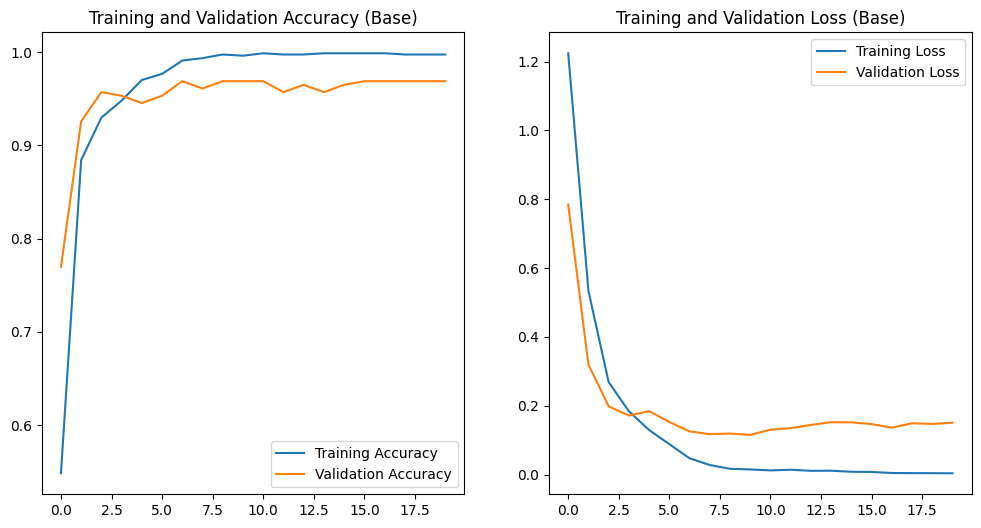

In [74]:
plot_accuracy_loss(history_resnet_functional)

In [75]:
y_true, y_pred = eval_model_on_test(model, test_ds)

print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:02<00:20,  2.95s/it]

1/1 [==============================] - 0s 103ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:03<00:08,  1.45s/it]

1/1 [==============================] - 0s 93ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:03<00:04,  1.03it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:04<00:02,  1.35it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:04<00:01,  1.65it/s]

1/1 [==============================] - 0s 81ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:04<00:01,  1.91it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:05<00:00,  2.15it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]

Accuracy of base model on test data: 93.81%
                       precision    recall  f1-score   support

waesche_0_model_front       0.87      0.92      0.89        49
     waesche_1_zoomed       1.00      1.00      1.00        35
 waesche_2_model_back       0.98      0.89      0.93        46
      waesche_3_ghost       0.91      0.91      0.91        45
       waesche_4_look       0.96      0.98      0.97        51

             accuracy                           0.94       226
            macro avg       0.94      0.94      0.94       226
         weighted avg       0.94      0.94      0.94       226



,0,1,2,3,4
0,45,0,1,2,1
1,0,35,0,0,0
2,4,0,41,1,0
3,3,0,0,41,1
4,0,0,0,1,50


In [76]:
# save model weights and model architecture to a single file
model.save('waesch_funcResnet_model_94%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
